In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
data.shape

(258210, 16)

In [4]:
test.shape

(83210, 16)

In [5]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline


In [6]:
data['province'].mode()

0    California
dtype: object

In [7]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [8]:
data.province.fillna(value='California', inplace=True)

In [9]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [10]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [11]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [12]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [13]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [14]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [15]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,2
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,Roger Voss,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,2
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,2


In [16]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [17]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [18]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [19]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [20]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [21]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9
0,0.115367,0.004577,0.114576,0.052600,0.007053,-0.030140,-0.028567,0.048136,0.033518,-0.001952
1,0.119707,0.024781,0.072052,0.020810,-0.011434,-0.058942,-0.000670,0.032345,0.002842,-0.003907
2,0.129262,0.101736,0.087996,0.003767,0.132171,-0.029115,-0.018475,0.021211,0.070716,-0.015295
3,0.103500,0.062100,0.012877,-0.065643,-0.018954,-0.061941,-0.012243,0.002271,0.044861,0.040505
4,0.096223,-0.056756,-0.015456,-0.013961,0.023635,0.028859,0.007216,0.016768,-0.041583,0.021444


In [22]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9
0,3.032120e-06,1.337161e-05,4.913872e-02,0.247638,-0.000035,0.000428,0.000055,0.000004,-0.000091,-0.182187
1,1.040262e-05,4.049609e-05,1.488026e-01,0.748054,-0.000036,0.000818,0.000092,0.000042,0.000326,0.613835
2,1.040261e-05,4.049612e-05,1.488026e-01,0.748054,-0.000036,0.000818,0.000092,0.000042,0.000326,0.613835
3,1.468151e-06,7.432294e-07,1.078796e-06,0.000001,-0.000019,0.000098,0.000635,0.000047,0.000512,0.001781
4,7.455420e-08,-7.984201e-08,8.913762e-07,0.000004,0.000011,0.000032,-0.000007,0.000039,0.000435,-0.000146


In [23]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9
0,5.925336e-11,1.200996e-06,-1.956747e-05,4.007309e-05,-6.045768e-06,-8.888895e-07,1.114052e-04,4.880635e-04,-4.205231e-04,-7.296001e-04
1,2.235818e-11,5.183323e-08,6.757844e-07,2.860715e-07,3.872704e-06,-1.234165e-05,9.999944e-01,-2.807267e-05,3.056361e-05,5.552538e-07
2,2.233295e-11,5.187322e-08,6.758526e-07,2.860965e-07,3.872704e-06,-1.234165e-05,9.999944e-01,-2.807267e-05,3.056361e-05,5.552538e-07
3,1.000000e+00,1.347806e-16,2.235682e-14,9.660473e-14,1.436970e-13,-1.486608e-13,-8.377258e-14,1.477783e-13,-4.773117e-13,-6.445777e-13
4,-5.012247e-14,1.000000e+00,1.367473e-09,1.677271e-09,2.400934e-09,-5.038300e-09,-5.069317e-09,2.907881e-09,-7.206291e-09,-6.635802e-10


In [24]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [25]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,-2.232226e-14,2.051388e-14,9.843308e-14,-2.381584e-14,3.717691e-13,2.898950e-14,1.000000e+00,1.251659e-14,2.758115e-14,5.855669e-14
1,-3.134754e-13,-1.605158e-10,1.000000e+00,-3.491195e-14,7.262601e-13,-3.633779e-14,1.980195e-13,2.794431e-13,4.481598e-14,5.388354e-15
2,-3.503589e-15,5.773532e-15,1.000000e+00,-1.240638e-14,-1.503551e-14,-1.559713e-14,7.495633e-14,1.095209e-13,4.775375e-14,1.849564e-14
3,1.000000e+00,-5.406059e-16,1.896116e-15,-2.112569e-13,-7.238449e-14,5.827077e-14,2.874840e-13,5.262341e-14,3.665465e-15,-8.260387e-15
4,1.000000e+00,-8.663049e-14,2.848422e-14,-9.255579e-12,-1.328876e-11,1.436682e-11,1.229377e-11,5.227233e-12,-3.490477e-15,2.938576e-15


In [26]:
dd = pd.concat([desc_features, var_features, prov_features, country_features], axis=1)
dd.shape

(258210, 40)

In [27]:
dd.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,0.115367,0.004577,0.114576,0.052600,0.007053,-0.030140,-0.028567,0.048136,0.033518,-0.001952,...,-2.232226e-14,2.051388e-14,9.843308e-14,-2.381584e-14,3.717691e-13,2.898950e-14,1.000000e+00,1.251659e-14,2.758115e-14,5.855669e-14
1,0.119707,0.024781,0.072052,0.020810,-0.011434,-0.058942,-0.000670,0.032345,0.002842,-0.003907,...,-3.134754e-13,-1.605158e-10,1.000000e+00,-3.491195e-14,7.262601e-13,-3.633779e-14,1.980195e-13,2.794431e-13,4.481598e-14,5.388354e-15
2,0.129262,0.101736,0.087996,0.003767,0.132171,-0.029115,-0.018475,0.021211,0.070716,-0.015295,...,-3.503589e-15,5.773532e-15,1.000000e+00,-1.240638e-14,-1.503551e-14,-1.559713e-14,7.495633e-14,1.095209e-13,4.775375e-14,1.849564e-14
3,0.103500,0.062100,0.012877,-0.065643,-0.018954,-0.061941,-0.012243,0.002271,0.044861,0.040505,...,1.000000e+00,-5.406059e-16,1.896116e-15,-2.112569e-13,-7.238449e-14,5.827077e-14,2.874840e-13,5.262341e-14,3.665465e-15,-8.260387e-15
4,0.096223,-0.056756,-0.015456,-0.013961,0.023635,0.028859,0.007216,0.016768,-0.041583,0.021444,...,1.000000e+00,-8.663049e-14,2.848422e-14,-9.255579e-12,-1.328876e-11,1.436682e-11,1.229377e-11,5.227233e-12,-3.490477e-15,2.938576e-15


In [28]:
dd.shape

(258210, 40)

In [29]:
#data.drop('index', axis=1, inplace=True)

In [30]:
dd['train_test'] = data.train_test.values

In [31]:
dd['id'] = data.id.values

In [32]:
dd['quality'] = data.quality.values

In [33]:
dd['points'] = data.points.values

In [34]:
dd['price'] = data.price.values

In [35]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 45)

In [36]:
final_data['div_points'] = final_data['points'].values / 2
final_data['div_points_4'] = final_data['points'].values / 4
final_data['div_points_8'] = final_data['points'].values / 8

In [37]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [38]:
final_data['description_0_x4'] = final_data['description_0'].multiply(4)
final_data['description_0_x4'].head()

0    0.461469
1    0.478829
2    0.517048
3    0.413999
4    0.384893
Name: description_0_x4, dtype: float64

In [39]:
final_data['description_1_x4'] = final_data['description_1'].multiply(4)
final_data['description_1_x4'].head()

0    0.018310
1    0.099122
2    0.406945
3    0.248401
4   -0.227026
Name: description_1_x4, dtype: float64

In [40]:
#final_data['div_points'].head(10)
final_data.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,price,div_points,div_points_4,div_points_8,sum_desc,sum_var,sum_prov,sum_country,description_0_x4,description_1_x4
0,0.115367,0.004577,0.114576,0.052600,0.007053,-0.030140,-0.028567,0.048136,0.033518,-0.001952,...,20.0,44.435437,22.217719,11.108859,0.315168,0.114967,-0.000536,0.114967,0.461469,0.018310
1,0.119707,0.024781,0.072052,0.020810,-0.011434,-0.058942,-0.000670,0.032345,0.002842,-0.003907,...,28.0,44.020848,22.010424,11.005212,0.197584,1.511985,0.999990,1.511985,0.478829,0.099122
2,0.129262,0.101736,0.087996,0.003767,0.132171,-0.029115,-0.018475,0.021211,0.070716,-0.015295,...,130.0,47.042511,23.521255,11.760628,0.483973,1.511985,0.999990,1.511985,0.517048,0.406945
3,0.103500,0.062100,0.012877,-0.065643,-0.018954,-0.061941,-0.012243,0.002271,0.044861,0.040505,...,34.0,44.934899,22.467449,11.233725,0.107335,0.003058,1.000000,0.003058,0.413999,0.248401
4,0.096223,-0.056756,-0.015456,-0.013961,0.023635,0.028859,0.007216,0.016768,-0.041583,0.021444,...,24.0,44.508825,22.254413,11.127206,0.066389,0.000369,1.000000,0.000369,0.384893,-0.227026


In [41]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [42]:
print(train_data.shape)
print(test_data.shape)

(175000, 54)
(83210, 54)


In [43]:
#cols = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'description_0_x4', 'description_1_x4']
#cols2 = ['points', 'quality']

In [44]:
#X = train_data[cols2]
#y = train_data["price"]

In [45]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [47]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [48]:
pf = PolynomialFeatures(degree=2, interaction_only=False,  
                        include_bias=False)
res = pf.fit_transform(final_data[['points', 'quality']])
res

array([[8.88708744e+01, 2.00000000e+00, 7.89803232e+03, 1.77741749e+02,
        4.00000000e+00],
       [8.80416953e+01, 2.00000000e+00, 7.75134011e+03, 1.76083391e+02,
        4.00000000e+00],
       [9.40850213e+01, 3.00000000e+00, 8.85199123e+03, 2.82255064e+02,
        9.00000000e+00],
       ...,
       [8.90575848e+01, 2.00000000e+00, 7.93125341e+03, 1.78115170e+02,
        4.00000000e+00],
       [8.49079088e+01, 1.00000000e+00, 7.20935297e+03, 8.49079088e+01,
        1.00000000e+00],
       [9.20387015e+01, 3.00000000e+00, 8.47112258e+03, 2.76116105e+02,
        9.00000000e+00]])

In [49]:
pd.DataFrame(pf.powers_, columns=['points_degree',  
                                  'quality_degree'])

,points_degree,quality_degree
0,1,0
1,0,1
2,2,0
3,1,1
4,0,2


In [129]:
intr_features = pd.DataFrame(res, columns=['points', 'quality',  
                                           'points^2', 
                                           'points x quality',  
                                           'quality^2'])
intr_features.head(5)

,points,quality,points^2,points x quality,quality^2
0,88.870874,2.0,7898.032315,177.741749,4.0
1,88.041695,2.0,7751.340111,176.083391,4.0
2,94.085021,3.0,8851.991227,282.255064,9.0
3,89.869797,2.0,8076.580454,179.739594,4.0
4,89.017651,2.0,7924.142166,178.035302,4.0


In [130]:
intr_features['points_log'] = np.log((1 + intr_features['points']))

In [131]:
intr_features['points^2_log'] = np.log((1 + intr_features['points^2']))

In [132]:
intr_features['points x quality_log'] = np.log((1 + intr_features['points x quality']))

In [133]:
import scipy.stats as spstats

In [134]:
#intr_features['points_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points']), lmbda=0)

In [135]:
#intr_features['points^2_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points^2']), lmbda=0)

In [136]:
#intr_features['points x quality_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points x quality']), lmbda=0)

In [172]:
l, opt_lambda = spstats.boxcox(intr_features['points'].values)
#opt_lambda

In [138]:
intr_features['points_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points']), 
                                          lmbda=opt_lambda)

In [139]:
intr_features['points^2_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points^2']), 
                                          lmbda=opt_lambda)

In [140]:
intr_features['points x quality_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points x quality']), 
                                          lmbda=opt_lambda)

In [141]:
intr_features.head()

,points,quality,points^2,points x quality,quality^2,points_log,points^2_log,points x quality_log,points_boxcox_lambda_opt,points^2_boxcox_lambda_opt,points x quality_boxcox_lambda_opt
0,88.870874,2.0,7898.032315,177.741749,4.0,4.498374,8.974496,5.185942,5.046263,11.334832,5.922886
1,88.041695,2.0,7751.340111,176.083391,4.0,4.489105,8.955750,5.176621,5.034650,11.305444,5.910799
2,94.085021,3.0,8851.991227,282.255064,9.0,4.554771,9.088511,5.646348,5.117035,11.514180,6.527014
3,89.869797,2.0,8076.580454,179.739594,4.0,4.509428,8.996848,5.197057,5.060118,11.369912,5.937307
4,89.017651,2.0,7924.142166,178.035302,4.0,4.500006,8.977796,5.187583,5.048308,11.340009,5.925015


In [142]:
print(intr_features.shape)

(258210, 11)


In [143]:
#intr_features.drop(['quality', 'quality^2'], inplace=True, axis=1)

In [144]:
final_data_c = final_data.drop(['points', 'quality'], axis=1)

In [145]:
ff = pd.concat([final_data_c, intr_features], axis=1)

In [146]:
print(ff.shape)

(258210, 63)


In [147]:
train_ff = ff[ff['train_test'] == 'train']
test_ff = ff[ff['train_test'] == 'test']

In [148]:
col_old3 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_2', 'variety_4', 'variety_6', 'variety_7', 'variety_9', 'province_0', 'province_5', 'province_6', 'province_7', 'province_9', 'country_0', 'country_2', 'country_9', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col_old2 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_2', 'variety_4', 'variety_6', 'variety_7', 'variety_9', 'province_5', 'province_6', 'province_7', 'province_9', 'country_0', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col_old1 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_7', 'province_6', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col0 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'province_6', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col00 = ['description_2', 'description_7', 'description_8', 'province_6', 'sum_prov', 'points_boxcox_lambda_opt']
col = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'description_0_x4', 'description_1_x4']

X = train_ff[col + intr_features.columns.tolist()]
y = train_ff["price"]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [150]:
print(X_train.columns.tolist())

['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'description_0_x4', 'description_1_x4', 'points', 'quality', 'points^2', 'points x quality', 'quality^2', 'points_log', 'points^2_log', 'points x quality_log', 'points_boxcox_lambda_opt', 'points^2_boxcox_lambda_opt', 'points x quality_boxcox_lambda_opt']


In [173]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:29.993
Will train until train-rmse hasn't improved in 10 rounds.
[1]	train-rmse:29.1757
[2]	train-rmse:28.8028
[3]	train-rmse:28.1655
[4]	train-rmse:27.6221
[5]	train-rmse:27.3047
[6]	train-rmse:27.1348
[7]	train-rmse:26.9765
[8]	train-rmse:26.7551
[9]	train-rmse:26.6956
Mean Squared Error: 33.99 


In [152]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [153]:
print(lm.intercept_)

5616.1798828261735


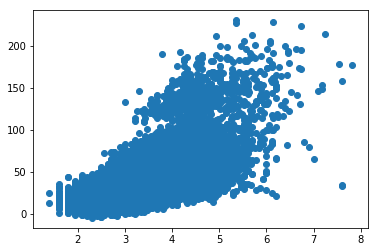

In [154]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [155]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 35.4555051666766


In [156]:
accuracy = lm.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.2952315470321625


In [157]:
rf = RandomForestRegressor()

In [165]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

In [166]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [167]:
predicts = rf.predict(X_test)

In [168]:
print(y_test.shape, predicts.shape)

(52500,) (52500,)


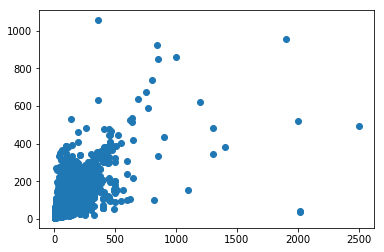

In [169]:
plt.scatter(y_test, predicts)

In [170]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 29.1836758545073


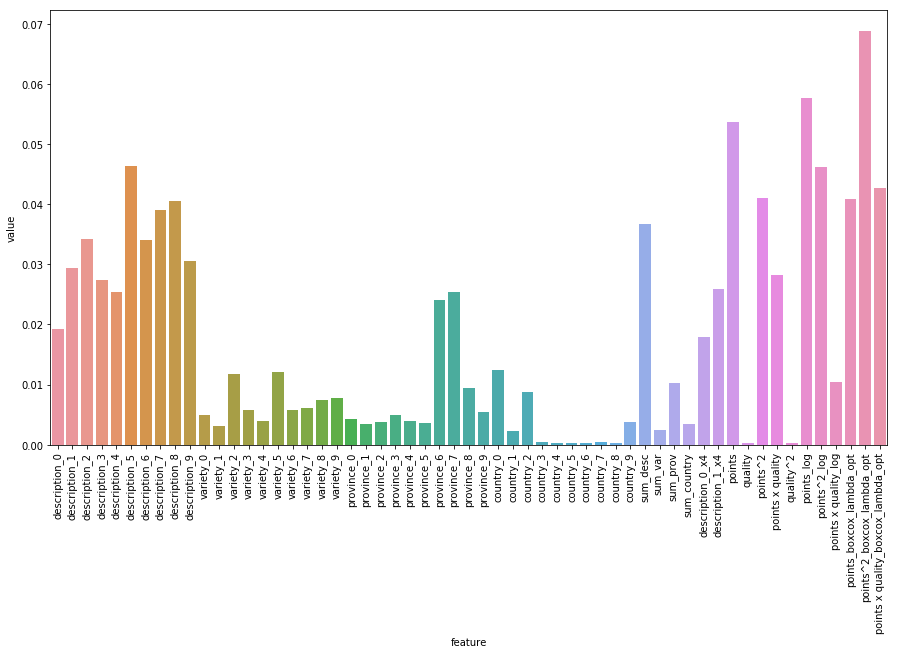

In [171]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)
print('')

In [ ]:
nnn

In [ ]:
#print(test_data.columns.tolist())

In [175]:
X_test_t = test_ff[col + intr_features.columns.tolist()]

In [176]:
print(X_train.shape, X_test_t.shape)

(122500, 57) (83210, 57)


In [178]:
test_ff['price'] = rf.predict(X_test_t)
test_ff['price'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    123.0
175001     67.9
175002     32.6
175003     26.6
175004     20.3
175005     21.7
175006     12.2
175007     29.3
175008     19.2
175009     58.3
Name: price, dtype: float64

In [180]:
#!pip3 install lightgbm

In [ ]:
test_ff[['id', 'price']].to_csv('bma_price_predicted_rmse_lm29_86.csv', index=False)

In [ ]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [ ]:
import pickle

In [ ]:
pickle.dump(rf,open('rf_model_rmse23_19.sav','wb'))